## Reading generated images

In [5]:
import io
import cv2
import json
import time
import requests
import numpy as np
from dotenv import load_dotenv 
from dotenv import dotenv_values
import urllib.request as request
from matplotlib import pyplot as plt
from matplotlib import ticker
from IPython.display import clear_output

DALLEE_IMAGE_URL = (
    "https://dgmd-s17-assets.s3.amazonaws.com/train/generated-text-images/"
)
USE_AWS_AI = True
LOCAL_AI_PORT = "5001"
AWS_AI_URL="http://34.192.30.136/"

OPENAI_KEY = ""
load_dotenv()
ENV_CONFIG = dict(dotenv_values(".env"))
try:
    OPENAI_KEY = ENV_CONFIG.get("OPENAI_KEY")
except KeyError:
    raise(Exception("Please write OPENAPI_KEY to .env"))


plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams["figure.dpi"] = 40

def setup_plt(keep_ticks=False):
    plt.clf()
    plt.close()
    ax = plt.gca()
    if keep_ticks == False:
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])
        
with open('merged.json', 'r') as rf:
    data = json.load(rf)

prompts = data["prompts"]
sources = data["images"]

In [2]:
try: sources
except NameError:
    raise(Exception("Please run prior cell"))

DELAY_READ = 0.001
NUM_READ = len(sources)
NUM_READ = 15 # TODO

images = []
print('LOADING IMAGES...')
src_subset = sources[:NUM_READ]
for src in src_subset:
    image_url = DALLEE_IMAGE_URL + src["file_name"]
    resp = requests.get(image_url, stream=True).raw
    arr = np.asarray(bytearray(resp.read()), dtype="uint8")
    decoded = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    if decoded is None:
        print('Unable to load', image_url)
        continue
    img = decoded[:,:,::-1]
    images.append((src,img))
    time.sleep(DELAY_READ)
    if len(images) % 10 == 0:
        clear_output(wait=True)
        print(round(100*len(images)/len(src_subset)),'%')
clear_output(wait=True)
print('LOADED', len(images), 'IMAGES!')

LOADED 15 IMAGES!


## Custom OCR

In [8]:
try: USE_AWS_AI
except NameError:
    raise(Exception("Please run first cell"))
try: AWS_AI_URL
except NameError:
    if (USE_AWS_AI == False): pass
    raise(Exception("Please run first cell"))
try: LOCAL_AI_PORT
except NameError:
    if (USE_AWS_AI == True): pass
    raise(Exception("Please run first cell"))

AI_SERVER_URL = (
    AWS_AI_URL if USE_AWS_AI else f'http://localhost:{LOCAL_AI_PORT}/'
)
print(f'Using Custom AI: {AI_SERVER_URL}')
for (i, (src,img)) in enumerate(images):
   bytes = bytearray(cv2.imencode('.png', img)[1])
   files = {'file': ('image.png', bytes, 'image/png', {'Expires': '0'})}
   endpoint = f'{AI_SERVER_URL}predict'
   response = requests.post(endpoint, files=files)
   print(endpoint, response.json())

Using Custom AI: http://34.192.30.136/
http://34.192.30.136/predict {'prediction': 'celery_seed', 'ocr_matches': ['allspice']}
http://34.192.30.136/predict {'prediction': 'caraway', 'ocr_matches': ['anise']}
http://34.192.30.136/predict {'prediction': 'cumin', 'ocr_matches': []}
http://34.192.30.136/predict {'prediction': 'caraway', 'ocr_matches': []}
http://34.192.30.136/predict {'prediction': 'caraway', 'ocr_matches': []}
http://34.192.30.136/predict {'prediction': 'sumac', 'ocr_matches': []}
http://34.192.30.136/predict {'prediction': 'ground_pepper', 'ocr_matches': ['caraway']}
http://34.192.30.136/predict {'prediction': 'celery_seed', 'ocr_matches': []}
http://34.192.30.136/predict {'prediction': 'sumac', 'ocr_matches': []}
http://34.192.30.136/predict {'prediction': 'fennel', 'ocr_matches': []}
http://34.192.30.136/predict {'prediction': 'saffron', 'ocr_matches': ['cumin', 'chiles']}
http://34.192.30.136/predict {'prediction': 'fennel', 'ocr_matches': ['chiles']}
http://34.192.30

## EasyOCR

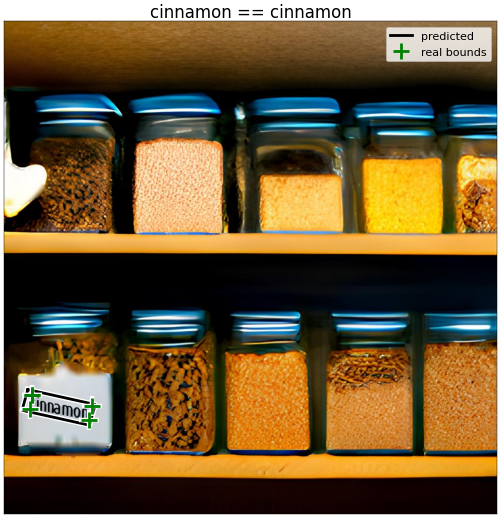

DONE


In [4]:
import easyocr

try: images
except NameError:
    raise(Exception("Please run prior cell"))

N_VIZ = len(images)
DELAY_VIZ = 0.0
print('LOADING MODEL...')
reader = easyocr.Reader(['en'])
def result_to_box(result):
    for r in result:
        yield np.round(r[0]).astype(int).tolist()
def result_to_words(result):
    # TODO -- fix source dataset
    ok_err = {
        'llspice': 'allspice'
    }
    for r in result:
        yield ok_err.get(r[1],r[1])
def src_to_words(src):
    meta_words = src["words"]
    for lines in meta_words:
        for word in lines["word"].split('\n'):
            yield word
def src_to_box(src):
    meta_words = src["words"]
    for box in meta_words:
        vecs = []
        for point in box["points"]:
            vecs.append([point["x"], point["y"]])
        yield vecs

real_values = []
result_values = []
for (i, (src,img)) in enumerate(images):
    real_box = list(src_to_box(src))
    real_words = list(src_to_words(src))
    real_text = ' '.join(real_words)
    real_values.append({
        "text": real_text,
        "bounds": real_box,
        "image": img
    })
    result = reader.readtext(img)
    result_box = list(result_to_box(result))
    result_words = list(result_to_words(result))
    result_text = ' '.join(result_words)
    result_values.append({
        "text": result_text,
        "bounds": result_box,
    })
    if len(real_values) % 10 == 0:
        print(round(100*len(real_values)/len(images)),'%')
    if (i >= N_VIZ):
        continue
    time.sleep(DELAY_VIZ)
    setup_plt()
    clear_output(wait=True)
    plt.imshow(img)

    # Calculate title
    correct = result_text == real_text
    sep = "==" if correct else "≠"
    plt.title(f'{result_text} {sep} {real_text}', fontsize = 30)

    # Draw predicted bounding boxes
    for (res_i, res_box) in enumerate(result_box):
        c = 'k'
        xs, ys = zip(*res_box)
        xs += (xs[0],)
        ys += (ys[0],)            
        l = 'predicted' if res_i == 0 else f'_res_{res_i}'
        plt.plot(xs,ys, 'w', label='_res_bg', linewidth=10)
        plt.plot(xs,ys, 'k', label=l, linewidth=5)
    
    # Draw real bounding boxes
    for (rea_i, rea_box) in enumerate(real_box):
        xs, ys = zip(*rea_box)
        xs += (xs[0],)
        ys += (ys[0],)    
        l = 'real bounds' if rea_i == 0 else f'_rea_{rea_i}'
        plt.plot(xs,ys, 'w+', label='_real_bg', mew=8, ms=35)
        plt.plot(xs,ys, 'g+', label=l, mew=5, ms=30)
        
    plt.legend(fontsize = 20)
    plt.show()
print('DONE')

# Evaluation

67 %


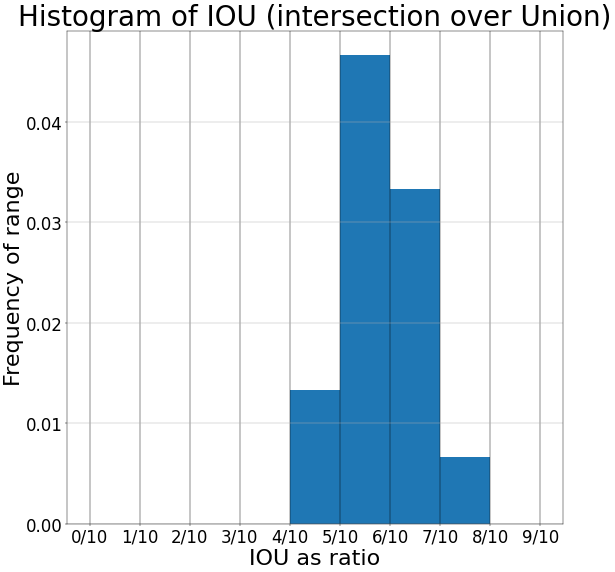

In [5]:
ious = []

try: real_values
except NameError:
    raise(Exception("Please run prior cell"))
    
# Assume all same shape
rea_canvas = np.zeros(real_values[0]["image"].shape[:2], dtype=np.float32)
res_canvas = np.zeros(real_values[0]["image"].shape[:2], dtype=np.float32)
for (rea, res) in zip(real_values, result_values):
    rea_canvas[:,:] = 0
    res_canvas[:,:] = 0
    # Render the real bounds
    for box in rea["bounds"]:
        cv2.fillPoly(rea_canvas, pts =[np.array(box)], color =(1))
    # Render the result bounds
    for box in res["bounds"]:
        cv2.fillPoly(res_canvas, pts =[np.array(box)], color =(1))

    # Calculate the union
    union = np.logical_or(rea_canvas > 0, res_canvas > 0)
    intersection = np.logical_and(rea_canvas > 0, res_canvas > 0)
    iou = round(100 * (intersection.sum() / union.sum()))
    ious.append(iou)
    if len(ious) % 10 == 0:
        print(round(100*len(ious)/len(real_values)),'%')

setup_plt(True)
bin_range = list(range(0,100,10))
plt.gca().xaxis.grid(True, color='k')
plt.gca().yaxis.grid(True)
plt.hist(ious, bins = bin_range, density = True)
plt.title(f'Histogram of IOU (intersection over Union)', fontsize = 50)
plt.tick_params(axis='both', which='major', labelsize = 30)
plt.xticks(bin_range, [f'{x//10}/10' for x in bin_range])

plt.xticks(bin_range)
plt.xlabel("IOU as ratio", fontsize=40)
plt.ylabel("Frequency of range", fontsize=40)
plt.show() # TODO
    

In [6]:
try: ious
except NameError:
    raise(Exception("Please run prior cell"))
    
MEAN_IOU = np.mean(ious)
TEXT_EQUALITY = [a["text"] == b["text"] for (a, b) in zip(real_values, result_values)]
TEXT_ACCURACY = int(np.array(TEXT_EQUALITY, dtype=bool).sum())/len(TEXT_EQUALITY)
MEAN_CORRECT_IOU = np.mean(np.array(ious)[TEXT_EQUALITY])

print(f'{round(MEAN_IOU, 3)}% mean IOU')
print(f'   {round(MEAN_CORRECT_IOU, 3)}% for true predictions')
print(f'\n{round(TEXT_ACCURACY*100, 3)}% text accuracy')

58.0% mean IOU
   59.417% for true predictions

80.0% text accuracy


In [7]:
from random import sample as samp
import openai
import time
import re
openai.api_key = OPENAI_KEY

In [8]:
try: TEXT_EQUALITY
except NameError:
    raise(Exception("Please run prior cell"))

N_GPT = 5
DELAY_GPT = 2.0

#api request instructions
def chat_with_gpt(prompt):
    response = openai.Completion.create(
        engine = 'text-davinci-003',
        prompt = prompt,
        max_tokens = 128,
        temperature = 0.5,
        n = 1,
        stop = None
    )

    #index selection of the responses generated by ChatGPT; choosing the first one
    if response.choices:
        lines = response.choices[0].text.split('\n')
        lines[0] = lines[0].replace(', and',',')
        lines[1] = lines[1].replace(', and',',')
        lines[0] = lines[0].replace(',',' +')
        lines[1] = lines[1].replace(',',' +')
        return '\n'.join(lines)
    else:
        return None

def to_prompt(spices):
    s = ', '.join(spices)
    return f'Please make a recipe from the following list of ingredients: {s}'

found_spices = set([v["text"] for (t,v) in zip(TEXT_EQUALITY, result_values) if t])
spice_lists = [samp(list(found_spices),samp([2,3,4],1)[0]) for _ in range(N_GPT)]
print(len(found_spices), 'spices available!\n')

for spices in spice_lists:
    clear_output(wait=True)
    print('INPUT SPICES:')
    prompt = to_prompt(spices)
    print('-', prompt[60:])
    output = chat_with_gpt(prompt)
    output = re.sub(r'Instructions.*', '', output, re.DOTALL)
    output = re.sub(r'\n\d.*', '', output, re.DOTALL)
    print('\nOUTPUT RECIPE:')
    print(re.sub(r'Instructions.*', '', output))
    time.sleep(DELAY_GPT)
    print('\n')



INPUT SPICES:
-  chili powder, cinnamon, ancho, cayenne

OUTPUT RECIPE:
 + onion + garlic

Chili-Spiced Onion and Garlic

Ingredients:

-1 large onion, chopped
-2 cloves garlic, minced
-2 teaspoons chili powder
-1 teaspoon ancho chili powder
-1/2 teaspoon cinnamon
-1/4 teaspoon cayenne pepper
-1 tablespoon olive oil







